<a href="https://colab.research.google.com/github/sidharth178/Face-Mask-Detection-and-Alert-System/blob/master/face_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align ="center"><b>=========== Face Mask Detection & Alert System ===========</h1>

# **Table of Contents**

1. Introduction
1. Fetch datasets from kaggle
1. Load Dataset
1. Import library
1. Data Augmentation
1. Model Building
1. Model Fitting
1. Training Loss & Accuracy Visualization
1. Find prediction



# **Introduction**
### **Objective**
The objective of this project is to detect the presence of a face mask on human faces on live streaming video as well as on images and alert the authority to take action on those who'r not wearing mask.
### **Dataset**
Click [here](https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset) to download the dataset.

The use of several datasets was necessary to collect different scenarios:
- People of different racial and ethnicities
- Masks of different types
- Masks in different positions
- Different Angles

<img align="center" src="https://miro.medium.com/max/875/1*MthYaQRvLAFJQqk65NcIsw.jpeg" width="30%" align="center"/>


# **1. Fetch datasets from kaggle**

In [102]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [103]:
# Step-2: create a API token in your kaggle account.Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
# Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json

mv: cannot stat '/content/sample_data/kaggle.json': No such file or directory


In [104]:
# Step-3: give authorization to KaggleApi
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [105]:
!chmod 600 ~/.kaggle/kaggle.json

In [106]:
# Step-4: Download datasets from kaggle using API
# !kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

covid-face-mask-detection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


# **2. Load Dataset**

In [107]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/covid-face-mask-detection-dataset.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

# **3. Import Libraries**

In [108]:
import os
import cv2
import numpy as np
import random
import keras

from imutils import paths
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report

# **4. Sample Image**
### **With Mask**

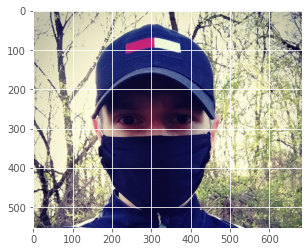

In [109]:
images_withMask = os.listdir("/content/sample_data/New Masks Dataset/Train/Mask")
sample_img_withMask = random.choice(images_withMask)
image = load_img("/content/sample_data/New Masks Dataset/Train/Mask/"+sample_img_withMask)
plt.imshow(image)

### **Without Mask**

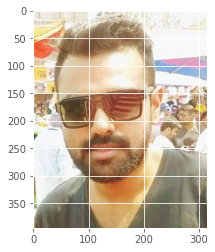

In [110]:
images_withoutMask = os.listdir("/content/sample_data/New Masks Dataset/Train/Non Mask")
sample_img_withoutMask = random.choice(images_withoutMask)
image = load_img("/content/sample_data/New Masks Dataset/Train/Non Mask/"+sample_img_withoutMask)
plt.imshow(image)

# **5. Data Augmentation**

In [111]:
# define constant
img_width=224
img_height=224

# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
train_data_dir="/content/sample_data/New Masks Dataset/Train"
test_data_dir="/content/sample_data/New Masks Dataset/Validation"

In [112]:
all_train_imagePaths = list(paths.list_images(train_data_dir))
all_test_imagePaths = list(paths.list_images(test_data_dir))
train_data = []
train_labels = []
test_data = []
test_labels = []

In [113]:
# loop over the image paths
for imagePath in all_train_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	train_data.append(image)
	train_labels.append(label)

In [114]:
# loop over the image paths
for imagePath in all_test_imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))

	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	test_data.append(image)
	test_labels.append(label)

In [115]:
def convert_data_labels(data,labels):
  # convert the data and labels to NumPy arrays
  data = np.array(data, dtype="float32")
  labels = np.array(labels)

  # perform one-hot encoding on the labels
  lb = LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return  data,labels

In [116]:
train_data,train_labels = convert_data_labels(train_data,train_labels)
test_data,test_labels = convert_data_labels(test_data,test_labels)

In [117]:
print("==================================")
print("Size of train dataset : ",train_data.shape[0])
print("==================================")
print("Size of test dataset : ",test_data.shape[0])
print("==================================")

Size of train dataset :  600
Size of test dataset :  306


In [118]:
# train datagen
train_datagen = ImageDataGenerator(
                  rotation_range=20,
                  zoom_range=0.15,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=0.15,
                  horizontal_flip=True,
                  fill_mode="nearest")

train_generator = train_datagen.flow(train_data, train_labels, batch_size=BS)

# **6. Model Building**

### **6.1. Load MobileNetV2**

In [119]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [120]:
# construct the head of the model that will be placed on top of the the base model
headModel = mobilenet.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [121]:
# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=mobilenet.input, outputs=headModel)

In [122]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("Done !!")


[INFO] compiling model...
Done !!


In [123]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in mobilenet.layers:
	layer.trainable = False

In [124]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

### **6.2. Callback Function**

In [125]:
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
# # history=model.fit(train_data,train_target,epochs=100,callbacks=[checkpoint],validation_split=0.2)
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/fmd_model.h5",
                             monitor='val_loss',
                             mode='auto',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [126]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

# **7. Model Fitting**

In [131]:
start_time=timer(None)
classifier = model.fit(
    train_datagen.flow(train_data, train_labels, batch_size=BS), 
    epochs=EPOCHS,
    validation_data=(test_data,test_labels),
    validation_steps=len(test_data)//BS,
    steps_per_epoch=len(train_data)//BS,
    callbacks=callbacks
)
timer(start_time)

Epoch 1/50
18/18 [==============================] - 10s 571ms/step - loss: 0.0301 - accuracy: 0.9931 - val_loss: 0.2692 - val_accuracy: 0.8889

Epoch 00001: val_loss improved from 0.28004 to 0.26923, saving model to /content/sample_data/fmd_model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
18/18 [==============================] - 10s 562ms/step - loss: 0.0153 - accuracy: 1.0000 - val_loss: 0.2652 - val_accuracy: 0.8889

Epoch 00002: val_loss improved from 0.26923 to 0.26525, saving model to /content/sample_data/fmd_model.h5
Epoch 3/50
18/18 [==============================] - 10s 538ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2712 - val_accuracy: 0.8889

Epoch 00003: val_loss did not improve from 0.26525

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
Epoch 4/50
18/18 [==============================] - 10s 526ms/step - loss: 0.0223 - accuracy: 0.9965 - val_loss: 0.2627 - val_accuracy: 0.8987

Epoch 00004: val_loss improved from 0.26525 to 0.26273, saving model to /content/sample_data/fmd_model.h5
Epoch 5/50
18/18 [==============================] - 10s 555ms/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 0.2377 - val_accuracy: 0.9183

Epoch 00005: val_loss improved from 0.26273 to 0.23772, saving model to /content

# **8. Training Loss and Accuracy Visualization**

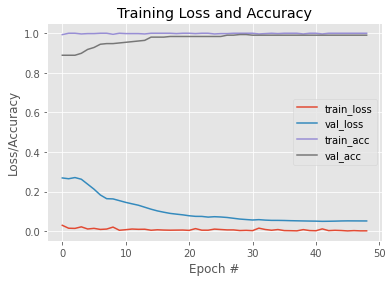

In [132]:
# plot the training loss and accuracy
plt.style.use("ggplot")
N = 10 # epochs number
plt.figure()
plt.plot( classifier.history["loss"], label="train_loss")
plt.plot( classifier.history["val_loss"], label="val_loss")
plt.plot( classifier.history["accuracy"], label="train_acc")
plt.plot( classifier.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

### **8.1. Find Prediction**

In [133]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(test_data, batch_size=BS)

[INFO] evaluating network...


In [134]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

### **8.2. Find Accuracy**

In [135]:
# check accuracy
val_loss,val_acc = model.evaluate(test_data,test_labels)
print("=======================================================")
print("Accuracy is : ",val_acc)
print("=======================================================")
print("Loss is : ",val_loss)
print("=======================================================")

10/10 [==============================] - 2s 89ms/step - loss: 0.0501 - accuracy: 0.9902
Accuracy is :  0.9901960492134094
Loss is :  0.05012531206011772


### **8.3. Classification Report**

In [137]:
# show a nicely formatted classification report
print(classification_report(test_labels.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.99      0.99      0.99       153

    accuracy                           0.99       306
   macro avg       0.99      0.99      0.99       306
weighted avg       0.99      0.99      0.99       306

